In [ ]:
import json
from pymongo import MongoClient
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
COLUMNS_NAME = ['Nº da Comanda',  'Vendedor', 'Combo', 'F. de Pagamento', 'Preço', 'Tamanho', 'Bairro', 'Cereais', 'Chocolates', 'Coberturas', 'Derivados do Leite', 'Diversos', 'Frutas', 'Obs', 'Data']
SELLER = ('seller', 'Vendedor')
COMBO = ('combos', 'Combo')
PAYMENT_OPTION = ('payment_option', 'F. de Pagamento')
SIZE = ('size', 'Tamanho')
NEIGHBORHOOD = ('neighborhood', 'Bairro')

In [ ]:
class ManipulationDB:
    def __init__(self) -> None:
        """Create connection in databases
        """
        #Connect MongoDB
        self.client = MongoClient('localhost', 27017)
        self.db = self.client['acaiteria']

        #Connect MySQL
        self.conn = mysql.connector.connect(host='localhost', user='root', passwd='', database='acaiteria')
    
    def create_dataframe(self, name_or_id_seller='id') -> pd.DataFrame:
        """Create data frame with data of sells
        Args:
            name_or_id_seller (str, optional): Supports 'name' or 'id' If name, the seller column in dataframe will receive seller's name, if not, it will receive the seller id. Defaults to 'id'.
        Returns:
            pd.DataFrame
        """
        i = dict()
        collection = self.db['comandas']
        cursor = collection.find({})
        df_main = pd.DataFrame(self.__pretty_json(cursor[0], name_or_id_seller), columns=COLUMNS_NAME)
        for i in cursor[1::]:
            df_temp = pd.DataFrame(self.__pretty_json(i, name_or_id_seller), columns=COLUMNS_NAME)
            df_main = pd.concat([df_main, df_temp])
        
        cursor.close()
        return df_main
    def __pretty_json(self, sheet: str, with_name='id') -> dict:
        """Create a pretty json format
        Args:
            sheet (str): dict of a record
            with_name (bool, optional): If True seller column will be seller name else will be ID seller. Defaults to False.
        Returns:
            dict: Dict containing record data 
        """
        old_json = sheet
        pretty_sheet = dict()
        pretty_sheet['number_sheet'] = old_json['n_comanda']
        pretty_sheet['seller'] = self._name_seller(old_json['seller']) if with_name  == 'name' else old_json['seller']
        pretty_sheet['combo'] = old_json['combo']
        pretty_sheet['payment_type'] = old_json['f_pagamento']
        pretty_sheet['price'] = old_json['preco']
        pretty_sheet['size'] = old_json['tamanho']
        pretty_sheet['neighborhood'] = old_json['bairro']
        pretty_sheet['cereals'] = list(i for i in old_json['cereais'])
        pretty_sheet['chocolates'] = list(i for i in old_json['chocolates'])
        pretty_sheet['covers'] = list(i for i in old_json['coberturas'])
        pretty_sheet['milk_derivatives'] = list(i for i in old_json['derivados do leite'])
        pretty_sheet['several'] = list(i for i in old_json['diversos'])
        pretty_sheet['fruits'] = list(i for i in old_json['frutas'])
        pretty_sheet['obs'] = old_json['obs']
        pretty_sheet['date'] = old_json['date_time']
        json_pretty = json.dumps(pretty_sheet, indent=4, ensure_ascii=False).encode('utf8')
        json_pretty = [json.loads(json_pretty.decode()).values()]
        return json_pretty
    
    def export_excel(self, dataframe: pd.DataFrame, path: str) -> None:
        """Export data frame to excel file
        Args:
            dataframe (pd.DataFrame): Data frame to convert excel file
            path (str): File path
        """
        dataframe.to_excel(path, 'Todas as Comandas', encoding='utf-8')
    
    def statistical_equations(self) -> dict:
        """Calculate statistical metrics
        Returns:
            tuple: Contaning claculations results
        """
        df = self.create_dataframe()
        
        sales_quantity = df['Nº da Comanda'].count()
        revenue = df['Preço'].sum()
        mean_sales = round(df['Preço'].mean(), 2)
        return {"Quantity": sales_quantity, "Revenue": revenue, "Mean_Sales": mean_sales}
    
    def count_type(self, names: tuple)-> pd.DataFrame:
        """Create data frame group by any colum type
        Args:
            names (tuple): Value used to group the column. Suppot values: SELLER, COMBO, PAYMENT_OPTION, SIZE, NEIGHBORHOOD
        Returns:
            pd.DataFrame: Data frame group by column 
        """
        df = self.create_dataframe()
        quantitys = dict()
        if names != SELLER:
            cursor = self.db['dadosGerais'].find({'_id': names[0]})
            types_names = list(i for i in cursor[0].keys() if i != '_id')
        else:
            cursor = self.conn.cursor()
            cursor.execute('SELECT id FROM empregados')
            types_names = list(map(lambda x: x[0], cursor))
        if names == SIZE:
            types_names = list(map(self.__str_numeric, types_names))
        for i in types_names:
            qtd = 0
            for j in df[names[1]]:
                if j == i:
                    qtd += 1
            quantitys[i] = qtd 
        quantity_any_thing = pd.DataFrame.from_dict(quantitys, orient='index', columns=['Qtd'])
        quantity_any_thing['index'] = quantity_any_thing.index
        cursor.close()
        return quantity_any_thing.sort_values(by='Qtd')
    
    def __str_numeric(self, str: str) -> int:
        """Return only number of a str
        Args:
            str (str): String to convert
        Returns:
            int: Only numbers os string
        """
        only_number = ''
        for i in str:
            if i.isnumeric():
                only_number += i
        if only_number == '1':
            only_number = '1000'
        return int(only_number)
    
    def _name_seller(self, id: int) -> str:
        """Return name of seller according to ID
        Args:
            id (int): ID seller
        Returns:
            str: NAme seller
        """
        cursor = self.conn.cursor()
        cursor.execute(f'SELECT primeiro_nome, sobrenome FROM empregados WHERE id = {id}')
        employee_name = list(map(lambda x: f'{x[0]} {x[1]}', cursor))
        cursor.close()
        return employee_name[0]

In [200]:
class Graphics:
    def __init__(self, type_data) -> None:
        self.type_data = type_data  
        self.df = ManipulationDB().count_type(self.type_data)
        self.top_five = self._top_five()

    def bar_graphic(self):
        plt.bar(self.top_five.keys(), self.top_five.values(), color='blue')
        plt.xticks(rotation='vertical')
        plt.xlabel('Vendedores')
        plt.ylabel('Qtd')
        plt.title(f'QUANTIDADE VENDIDA POR {self.type_data[1].upper()}')
        plt.show()
    
    def pie_graphic(self):
        plt.pie(self.top_five.values(), 
            labels=self.top_five.keys(),
            shadow = True, 
            startangle=180,
            autopct='%.2f')
        plt.show()

    def _top_five(self):
        quantity_register = self.df['index'].count() - 1
        top_five = {}
        if quantity_register >= 5:
            qtd_items = 5
        else:
            qtd_items = quantity_register + 1
        for i in range(qtd_items):
            if self.type_data == SELLER:
                name = ManipulationDB()._name_seller(self.df['index'].iloc[quantity_register- i]).split(' ')[0]
                top_five[name] = self.df['Qtd'].iloc[quantity_register - i]
            else:
                top_five[self.df['index'].iloc[quantity_register- i]] = self.df['Qtd'].iloc[quantity_register- i]
            if i == qtd_items - 1:
                fifth_item = quantity_register - 5 
                other = 0
                for j in range(fifth_item):
                    other += self.df['Qtd'].iloc[fifth_item - j]
                if other != 0:
                    top_five['Outros'] = other
        return top_five
                    

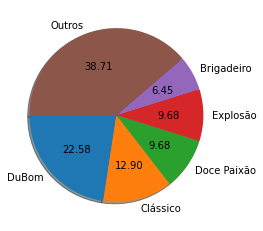

In [202]:
Graphics(COMBO).pie_graphic()